In [1]:
#load packages
import numpy as np
from netCDF4 import Dataset
import pickle as pickle
import scipy.stats as stats
import scipy.signal as signal
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
%matplotlib inline
mpl.rc('font',size=16) #set default font size and weight for plots

In [92]:
#user defined inputs
datdir1 = '/Users/Karen/Dropbox/CESM/python/CESM/'
var = 'MOC'
fileend = '.allyrs.ATL.nc'
month = ['11', '12', '01', '02', '03','04','05','06','07','08','09','10','11','12']

#open netcdf files
varnames = dict()
for i in range(len(month)):
    fname1        = var + '.monthly.' + month[i] + fileend
    nc1           = Dataset(fname1)
    varnames_tmp1 = np.squeeze(nc1.variables[var][:,:,:])
    varnames[i] = np.ma.masked_greater(varnames_tmp1,1e20)
    
    z             = nc1.variables['moc_z'][:]
    lat           = nc1.variables['lat_aux_grid'][:]

In [93]:
varnames[0].shape

(1101, 61, 302)

In [94]:
#create SSW seasons (oct-apr) (also restrict latitudes to NH only lat[1:121])
#var_ssws = np.stack((varnames[0][0:varnames[0].shape[0]-1,:,:],varnames[1][0:varnames[0].shape[0]-1,:,:],
                     #varnames[2][1:varnames[0].shape[0],:,:],varnames[3][1:varnames[0].shape[0],:,:],
                     #varnames[4][1:varnames[0].shape[0],:,:]))

In [95]:
var_ssws = np.stack((varnames[0][0:varnames[0].shape[0]-1,:,:],varnames[1][0:varnames[0].shape[0]-1,:,:],
                     varnames[2][1:varnames[0].shape[0],:,:],varnames[3][1:varnames[0].shape[0],:,:],
                     varnames[4][1:varnames[0].shape[0],:,:],varnames[5][1:varnames[0].shape[0],:,:],
                     varnames[6][1:varnames[0].shape[0],:,:],varnames[7][1:varnames[0].shape[0],:,:],
                     varnames[8][1:varnames[0].shape[0],:,:],varnames[9][1:varnames[0].shape[0],:,:],
                     varnames[10][1:varnames[0].shape[0],:,:],varnames[11][1:varnames[0].shape[0],:,:],
                     varnames[12][1:varnames[0].shape[0],:,:],varnames[13][1:varnames[0].shape[0],:,:]))

In [96]:
Nm,Ny,Nh,Nl = var_ssws.shape

In [97]:
#Now, calculate standardized zonal wind anomalies
#sst_bar = np.ma.mean(var_ssws,axis=1)
#sst_std = np.ma.std(var_ssws,axis=1)
#sst_norm = np.reshape(var_ssws,(Ny,Nm,Nh,Nl))/sst_std

In [98]:
ssta = np.ma.MaskedArray.anom(var_ssws,axis=1)
#ssts = np.reshape(np.ma.MaskedArray.anom(sst_norm,axis=0),(Nm,Ny,Nh,Nl))

In [99]:
ssta.shape

(14, 1100, 61, 302)

In [100]:
#AMOC at 35N and 1000m
moc_max = ssta[:,:,40,104]

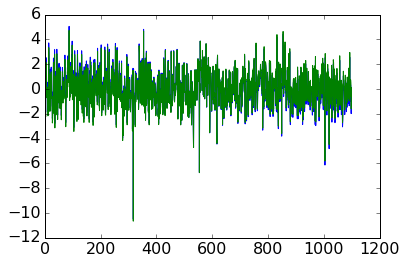

In [101]:
moc_max_jfm = np.mean(moc_max[2:5,:],axis=0)
plt.plot(moc_max_jfm)
plt.plot(moc_jfm)

In [102]:
#seasonal averages
ssta_jfm = signal.detrend(np.mean(ssta[2:5,:,:,:],axis=0),axis=0) #average over JFM
#ssta_amj = np.mean(ssta[3:6,:,:,:],axis=0) #average over AMJ
#ssta_jas = np.mean(ssta[6:9,:,:,:],axis=0) #average over JAS
ssta_ann = signal.detrend(np.mean(ssta[2:14,:,:,:],axis=0),axis=0) #Annual mean
moc_jfm = signal.detrend(np.mean(moc_max[2:5,:],axis=0),axis=0)  #average over JFM

In [103]:
#latm_box = lat[74:115]
#zm_box = z[33:47]

In [104]:
ssta_jfm.shape

(1100, 61, 302)

In [105]:
#find MOC maximum (or average) transport in box(0.5-2km, 25-45N)
from area_diags import area_avg

moc_box = ssta_jfm[:,33:47,115:152]
latm_box = lat[115:152]
zm_box = z[33:47]
#for depth-weighting
dz = np.zeros((zm_box.size))
zm_box_tmp = z[33:48]
for i in range(zm_box_tmp.size-1):
    dz[i] = zm_box_tmp[len(zm_box_tmp) - 1 - i] - zm_box_tmp[len(zm_box_tmp) - i - 2]
dz = np.flipud(dz)
dz_sum = np.sum(dz)
moc_box_max = np.ma.zeros((moc_box.shape[0]))

#area average to great timeseries
p = area_avg.averages()
moc_box_tmp = np.ma.zeros((moc_box.shape[0],moc_box.shape[1]))
for j in range(moc_box.shape[1]):
    moc_box_tmp[:,j] = p.Latavg(var=np.squeeze(moc_box[:,j,:]), lat=latm_box)
moc_box_max = np.sum(moc_box_tmp*dz/dz_sum,axis=1)

In [106]:
#seasonal climatologies
sst_bar_jfm = np.mean(np.mean(var_ssws[2:5,:,:,:],axis=0),axis=0) 
#sst_bar_amj = np.mean(np.mean(var_ssws[3:6,:,:,:],axis=0),axis=0) 
#sst_bar_jas = np.mean(np.mean(var_ssws[6:9,:,:,:],axis=0),axis=0) 
sst_bar_ann = np.mean(np.mean(var_ssws[2:14,:,:,:],axis=0),axis=0)

sst_std_jfm = np.std(np.mean(var_ssws[2:5,:,:,:],axis=0),axis=0) 
#sst_std_amj = np.std(np.mean(var_ssws[3:6,:,:,:],axis=0),axis=0) 
#sst_std_jas = np.std(np.mean(var_ssws[6:9,:,:,:],axis=0),axis=0) 
sst_std_ann = np.std(np.mean(var_ssws[2:14,:,:,:],axis=0),axis=0)

In [107]:
#linearly detrend MOC (there is a drift in the MOC over the first 200 years)
ssta_jfm_dtr = signal.detrend(ssta_jfm,axis=0)

In [108]:
#diff = ssta_jfm - ssta_jfm_dtr

In [2]:
#unpickle SSW central dates
with open('ENSO_NDJF_years_rev.pickle','rb') as fp:
    elnino_yrs,lanina_yrs = pickle.load(fp,encoding='latin1')

In [5]:
lanina_yrs.shape

(353, 1)

In [112]:
##create composite of El Nino/La Nina years
ElNinoyrs = ssta_jfm[np.squeeze(elnino_yrs),:,:]
ElNinoyrs_composite = np.mean(ElNinoyrs,axis=0)

LaNinayrs = ssta_jfm[np.squeeze(lanina_yrs),:,:]
LaNinayrs_composite = np.mean(LaNinayrs,axis=0)


ElNinoyrs_ann = ssta_ann[np.squeeze(elnino_yrs),:,:]
ElNinoyrs_composite_ann = np.mean(ElNinoyrs_ann,axis=0)

LaNinayrs_ann = ssta_ann[np.squeeze(lanina_yrs),:,:]
LaNinayrs_composite_ann = np.mean(LaNinayrs_ann,axis=0)

In [113]:
ElNinoyrs_moc = moc_box_max[np.squeeze(elnino_yrs)]
LaNinayrs_moc = moc_box_max[np.squeeze(lanina_yrs)]
print np.mean(ElNinoyrs_moc), np.mean(LaNinayrs_moc)

-0.943188294183 0.658907199906


In [114]:
#pickle the dates for later use
#with open('MOC_ElNino_JFM_composite_years_CP07.pickle','wb') as fp:
#    pickle.dump(ElNinoyrs_moc,fp)
#with open('MOC_LaNina_JFM_composite_years_CP07.pickle','wb') as fp:
#    pickle.dump(LaNinayrs_moc,fp)

In [115]:
#test significance of ENSO composite mean anomalies
tp1 = stats.ttest_1samp(ElNinoyrs,0.0,axis=0)
tp2 = stats.ttest_1samp(LaNinayrs,0.0,axis=0)

tp3 = stats.ttest_1samp(ElNinoyrs_ann,0.0,axis=0)
tp4 = stats.ttest_1samp(LaNinayrs_ann,0.0,axis=0)

In [116]:
#for some reason ma.masked_outside did not work and ma.masked_where with two conditions also did not work
p1 = np.ma.masked_invalid(tp1[1])
p1 = np.ma.masked_where(p1>=0.05,p1)
p1 = np.ma.masked_where(p1==0,p1)
p1[~p1.mask]=1

p2 = np.ma.masked_invalid(tp2[1])
p2 = np.ma.masked_where(p2>=0.05,p2)
p2 = np.ma.masked_where(p2==0,p2)
p2[~p2.mask]=1


p3 = np.ma.masked_invalid(tp3[1])
p3 = np.ma.masked_where(p3>=0.05,p3)
p3 = np.ma.masked_where(p3==0,p3)
p3[~p3.mask]=1

p4 = np.ma.masked_invalid(tp4[1])
p4 = np.ma.masked_where(p4>=0.05,p4)
p4 = np.ma.masked_where(p4==0,p4)
p4[~p4.mask]=1

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in greater_equal


In [117]:
xx, yy = np.meshgrid(lat[94:],z/100000)

In [118]:
#only plot significant values
ElNino_sig = np.ma.masked_where(p1!=1,ElNinoyrs_composite)
LaNina_sig = np.ma.masked_where(p2!=1,LaNinayrs_composite)

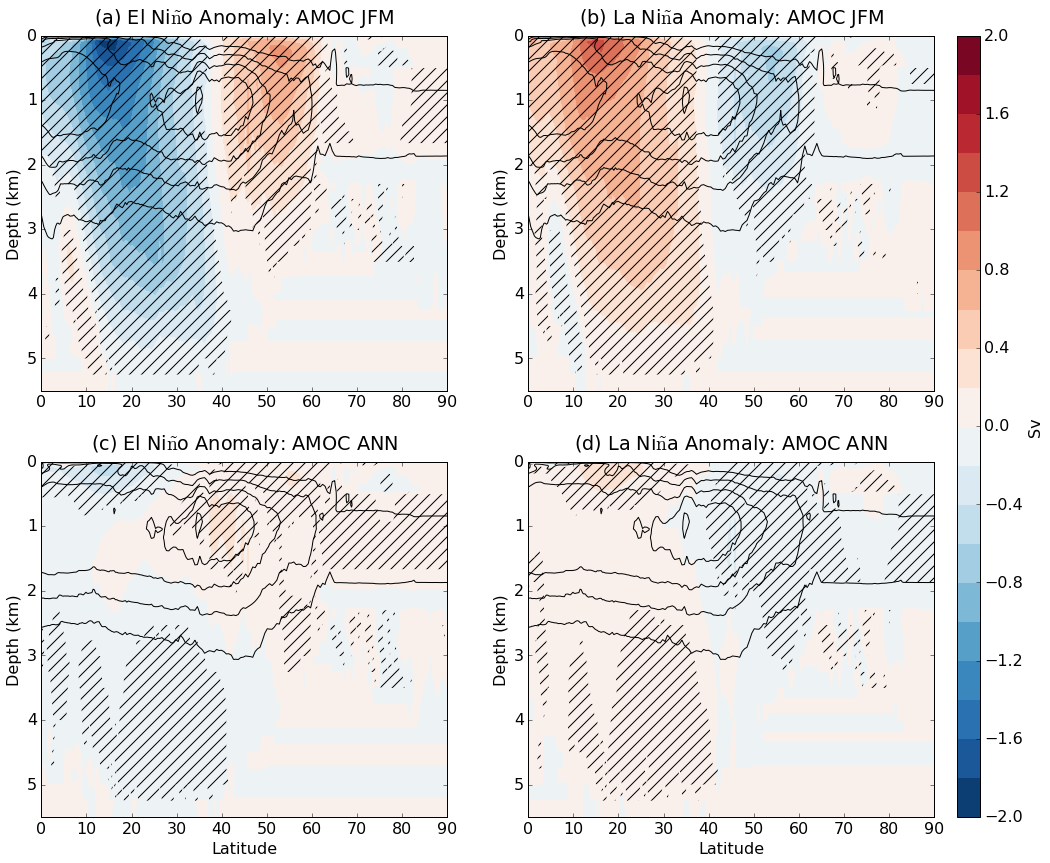

In [124]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))

vmin = np.around(np.min(LaNinayrs_composite),decimals=2)
vmax = np.around(np.max(LaNinayrs_composite),decimals=2)
if np.abs(vmin) > np.abs(vmax):
    vint = np.abs(np.around((vmin)/12,decimals=3))
    vmax = np.abs(vmin)
else:
    vint = np.around((vmax)/12,decimals=3)
    vmin = -vmax

#v = np.linspace(float(vmin)-float(vint),float(vmax)+float(vint),13)
v = np.linspace(-2,2,21)
v2 = np.linspace(-2,2,11)
#v = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
clevs = [-5, 5, 10, 15, 20, 25]



ax1.contourf(xx,yy,ElNinoyrs_composite[:,94:],v,cmap='RdBu_r')
ax1.contour(xx,yy,sst_bar_jfm[:,94:],clevs,colors='k')
ax1.contourf(xx,yy,p1[:,94:],colors = 'none', hatches=['//'])
ax1.invert_yaxis()
#ax1.set_xlabel('Latitude')
ax1.set_ylabel('Depth (km)')
ax1.set_title(r'(a) El Ni$\~{\rm n}$o Anomaly: AMOC JFM', y=1.02)

#plt.tight_layout()

#add colorbar
#cbar = fig.colorbar(pc1)
#cbar.set_label('Sv', fontsize=16)
#cbar.set_ticks(v2,update_ticks=True)
#cbar.ax.tick_params(labelsize=16)

ax2.contourf(xx,yy,LaNinayrs_composite[:,94:],v,cmap='RdBu_r')
ax2.contour(xx,yy,sst_bar_jfm[:,94:],clevs,colors='k')
ax2.contourf(xx,yy,p2[:,94:],colors = 'none', hatches=['//'])
ax2.invert_yaxis()
#ax2.set_xlabel('Latitude')
ax2.set_ylabel('Depth (km)')
ax2.set_title(r'(b) La Ni$\~{\rm n}$a Anomaly: AMOC JFM', y=1.02)

ax3.contourf(xx,yy,ElNinoyrs_composite_ann[:,94:],v,cmap='RdBu_r')
ax3.contour(xx,yy,sst_bar_ann[:,94:],clevs,colors='k')
ax3.contourf(xx,yy,p3[:,94:],colors = 'none', hatches=['//'])
ax3.invert_yaxis()
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Depth (km)')
ax3.set_title(r'(c) El Ni$\~{\rm n}$o Anomaly: AMOC ANN', y=1.02)

#plt.tight_layout()

#add colorbar
#cbar = fig.colorbar(pc1)
#cbar.set_label('Sv', fontsize=16)
#cbar.set_ticks(v2,update_ticks=True)
#cbar.ax.tick_params(labelsize=16)

ax4.contourf(xx,yy,LaNinayrs_composite_ann[:,94:],v,cmap='RdBu_r')
ax4.contour(xx,yy,sst_bar_ann[:,94:],clevs,colors='k')
ax4.contourf(xx,yy,p4[:,94:],colors = 'none', hatches=['//'])
ax4.invert_yaxis()
ax4.set_xlabel('Latitude')
ax4.set_ylabel('Depth (km)')
ax4.set_title(r'(d) La Ni$\~{\rm n}$a Anomaly: AMOC ANN', y=1.02)

#plt.tight_layout()

#add colorbar
caxes = fig.add_axes([0.92, 0.125, 0.02, 0.775]) 
cbar = fig.colorbar(pc2,caxes)
cbar.set_label('Sv', fontsize=16)
cbar.set_ticks(v2,update_ticks=True)
cbar.ax.tick_params(labelsize=16)

#save figure
plt.savefig('MOC_JFM_ANN_ENSO.eps',bbox_inches='tight')

In [181]:
#user defined inputs
datdir1 = '/d2/ksmith/waccmdata/CO2x1SmidEmin_yBWCN/ocn/interp'
datdir2 = '/d11/ksmith/waccmdata/CO2x1SmidEmin_yBWCN/ocn/interp'
var = 'HMXL'
fileend = '.allyrs.ATL.nc'
month = ['11', '12', '01', '02', '03']

#open netcdf files
varnames = dict()
for i in range(len(month)):
    fname1        = datdir1 + '/' + var + '.' + month[i] + fileend
    nc1           = Dataset(fname1)
    varnames_tmp1 = np.squeeze(nc1.variables[var][:,:,:,:])
    varnames_tmp1 = np.ma.masked_greater(varnames_tmp1,1e20)
    varnames_tmp1 = np.ma.mean(varnames_tmp1,axis=1)
    
    fname2        = datdir2 + '/' + var + '.' + month[i] + fileend
    nc2           = Dataset(fname2)
    varnames_tmp2 = np.squeeze(nc2.variables[var][:,:,:,:])
    varnames_tmp2 = np.ma.masked_greater(varnames_tmp2,1e20)
    varnames_tmp2 = np.ma.mean(varnames_tmp2,axis=1)
    
    varnames[i]  = np.concatenate((varnames_tmp2,varnames_tmp1),axis=0)
    lon          = nc1.variables['lon'][:]
    lat          = nc1.variables['lat'][:]

In [182]:
#create SSW seasons (oct-apr) (also restrict latitudes to NH only lat[1:121])
var_ssws = np.stack((varnames[0][0:varnames[0].shape[0]-1,:,:],varnames[1][0:varnames[0].shape[0]-1,:,:],
                     varnames[2][1:varnames[0].shape[0],:,:],varnames[3][1:varnames[0].shape[0],:,:],
                     varnames[4][1:varnames[0].shape[0],:,:]))

In [183]:
Nm,Ny,Nh,Nl = var_ssws.shape

In [184]:
#Now, calculate standardized zonal wind anomalies
sst_bar = np.ma.mean(var_ssws,axis=1)
sst_std = np.ma.std(var_ssws,axis=1)
sst_norm = np.reshape(var_ssws,(Ny,Nm,Nh,Nl))/sst_std
ssta = np.ma.MaskedArray.anom(var_ssws,axis=1)
ssts = np.reshape(np.ma.MaskedArray.anom(sst_norm,axis=0),(Nm,Ny,Nh,Nl))

In [204]:
#seasonal averages
ssta_jfm = np.mean(ssta[2:5,:,:,:],axis=0) #average over JFM
#ssta_amj = np.mean(ssta[3:6,:,:,:],axis=0) #average over AMJ
#ssta_jas = np.mean(ssta[6:9,:,:,:],axis=0) #average over JAS
#ssta_ann = np.mean(ssta,axis=0)            #Annual mean

In [205]:
#unpickle SSW central dates
with open('WACCM_nossw_central_dates_CP07_all_ElNino.pickle','rb') as fp:
    elnino_central_dates = pickle.load(fp)

In [206]:
#unpickle SSW central dates
with open('WACCM_nossw_central_dates_CP07_all_LaNina.pickle','rb') as fp:
    lanina_central_dates = pickle.load(fp)

In [207]:
##create composite of El Nino/La Nina years
ElNinoyrs = ssta_jfm[elnino_central_dates,:,:]
ElNinoyrs_composite = np.mean(ElNinoyrs,axis=0)

LaNinayrs = ssta_jfm[lanina_central_dates,:,:]
LaNinayrs_composite = np.mean(LaNinayrs,axis=0)

In [208]:
#test significance of ENSO composite mean anomalies
tp1 = stats.ttest_1samp(ElNinoyrs,0.0,axis=0)
tp2 = stats.ttest_1samp(LaNinayrs,0.0,axis=0)

In [209]:
#for some reason ma.masked_outside did not work and ma.masked_where with two conditions also did not work
p1 = np.ma.masked_invalid(tp1[1])
p1 = np.ma.masked_where(p1>=0.05,p1)
p1 = np.ma.masked_where(p1==0,p1)
p1[~p1.mask]=1

p2 = np.ma.masked_invalid(tp2[1])
p2 = np.ma.masked_where(p2>=0.05,p2)
p2 = np.ma.masked_where(p2==0,p2)
p2[~p2.mask]=1

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater_equal


In [210]:
#define projection
xx, yy = np.meshgrid(lon, lat)
mm = Basemap(projection='cyl', lon_0 = -45, llcrnrlon=270, llcrnrlat=0, urcrnrlon=360, urcrnrlat=80)
x, y = mm(xx,yy) #converts rectangular meshgrid into meshgrid for the specific projection

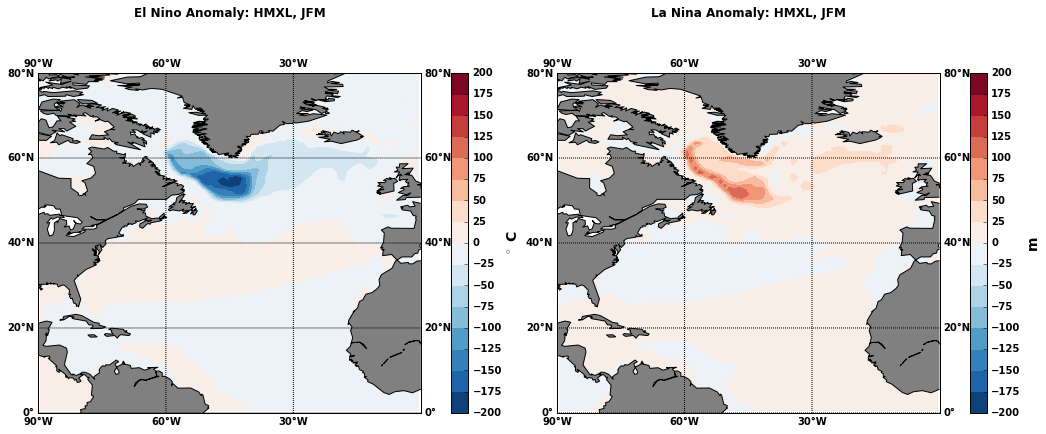

In [214]:
#plot in stereographic projetion
fig = plt.figure(figsize=(16,6))
v = np.linspace(-200,200,17)

ax1 = fig.add_subplot(1,2,1)
mm.drawcoastlines()
mm.drawmapboundary(fill_color='none')
pc1 = mm.contourf(x,y, ElNinoyrs_composite/100, v, cmap='RdBu_r')
pc1.set_clim(-200,200)
#pc2 = mm.scatter(x,y, p1,c='gray')
mm.fillcontinents(color='gray')
mm.drawparallels(range(0,90,20), labels=[1,1,0,0])
mm.drawmeridians(range(30,360,30), labels=[0,0,1,1])
plt.title('El Nino Anomaly: HMXL, JFM', y=1.15, weight='bold')

plt.tight_layout()

#add colorbar
cbar = fig.colorbar(pc1)
cbar.set_label('$^\circ$ C', fontsize=14,weight='bold') #$^\circ$ C
cbar.set_ticks(v,update_ticks=True)

ax2 = fig.add_subplot(1,2,2)
mm.drawcoastlines()
mm.drawmapboundary(fill_color='none')
pc2 = mm.contourf(x,y, LaNinayrs_composite/100, v, cmap='RdBu_r')
pc2.set_clim(-200,200)
#pc2 = mm.scatter(x,y, p1,c='gray')
mm.fillcontinents(color='gray')
mm.drawparallels(range(0,90,20), labels=[1,1,0,0])
mm.drawmeridians(range(30,360,30), labels=[0,0,1,1])
plt.title('La Nina Anomaly: HMXL, JFM', y=1.15, weight='bold')

plt.tight_layout()

#add colorbar
cbar = fig.colorbar(pc2)
cbar.set_label('m', fontsize=14,weight='bold') #$^\circ$ C
cbar.set_ticks(v,update_ticks=True)

#save figure
plt.savefig('HMXL_JFM_ENSO_composites_allyrs_noSSWs.eps',bbox_inches='tight')